In [1]:
import os
import numpy as np
import board
import pickle
import board as Board
import player
import game
from copy import deepcopy
import mcts
import matplotlib.pyplot as plt

from neural_network import*

In [2]:
player1 = player.Zero_Player('x', 'Bot_ZERO', nn_type="w", temperature=1)
player2 = player.Zero_Player('o', 'Bot_ZERO', nn_type="w", temperature=1)
players = [player1, player2]
tree = mcts.MCTS()
brd = Board.Board()

test = np.array([[  0,   0,  0],
                 [  0,   0,   0],
                 [  0,   0,  0]])


brd.board = test
PATH = {"path":[]}


# self_play_game = game.Game(player1, player2, tree)
# self_play_game.board = brd
# self_play_results = self_play_game.play(100)
# cnn_model = CNN_Model()

In [ ]:
train_data = update_nn_training_set(tree.EDGES, tree.TREE)

In [ ]:
import keras
from keras.layers import Input, Dense, Concatenate
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling1D, MaxPooling2D
from keras.optimizers import SGD
from keras import initializers
from keras.regularizers import l2

Input_1 = Input(shape=(3, 3, 1))

x1 = Conv2D(filters=4, kernel_size=(1, 3), activation='relu',
            kernel_regularizer=l2(0.0005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x2 = Conv2D(filters=4, kernel_size=(3, 1), activation='relu',
            kernel_regularizer=l2(0.0005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x3 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
            kernel_regularizer=l2(0.0005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x1 = MaxPooling2D((3, 1))(x1)
x2 = MaxPooling2D((1, 3))(x2)
x3 = MaxPooling2D((1, 1))(x3)

x = Concatenate()([x1, x2, x3])
x = Flatten()(x)

value_head = Dense(10, activation='relu')(x)
value_head = Dense(1, activation='relu', name="V")(value_head)

policy_head = Dense(90, activation='relu')(x)
policy_head = Dense(10, activation='softmax', name="P")(policy_head)

model = Model(inputs=Input_1, outputs=[value_head, policy_head])
opt = SGD(lr=0.01, momentum=0.09)
model.compile(optimizer="adam",
              loss={"V": "mse", "P":"categorical_crossentropy"},
              loss_weights = [.9,.1],
              metrics=['acc'])


In [ ]:
X_clean = train_data[0]
Y_value = train_data[1]
# values are between 0 and 1, multiply by 2 to get range(0,2)
targets = (Y_value * 2).round()
Y_value_one_hot = np.eye(3)[targets.astype(int)]

Y_policy = train_data[2]

X_final = np.stack([X_clean], axis=-1)
model.fit(X_final, [Y_value, Y_policy], epochs=100, verbose=1)

In [ ]:
Y_policy[0]

In [ ]:
Y_value[0]

In [67]:
model = keras.models.load_model("./best_keras_model.tf")

In [41]:
player1.keras_nn = model
player2.keras_nn = model

In [5]:
test = np.array([[  0,   0,  0],
                 [  0,   0,  0],
                 [  0,   0,  0]])

brd = Board.Board()
brd.board = test
player1.keras_nn = model
player1.nn_turn(brd)

(1, 0, 1)

In [ ]:
test = np.array([[  0,   0,  0],
                 [  1,   0,  0],
                 [  0,   0,  -1]])

brd = Board.Board()
brd.board = test
player2.keras_nn = model
player2.nn_turn(brd)

In [ ]:
test = np.array([[  0,   0,  0],
                 [  0,   0,  0],
                 [  0,   0,  0]])

brd = Board.Board()
brd.board = test
player1.keras_nn = model
player1.nn_turn(brd)

In [ ]:
test = np.array([[  -1,   0,  1],
                 [  0,   -1,   0],
                 [  1,   -1,  1]])

brd = Board.Board()
brd.board = test
player1.keras_nn = model
player1.nn_turn(brd)

In [6]:
from statistics import *

In [68]:
test = np.array([[  -1,   1,  0],
                 [  0,   1,  0],
                 [  0,   -1,  0]])

# test = np.array([[  1,   -1,  0],
#                  [  0,   -1,  0],
#                  [  0,   0,  1]])

n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])

p1_win = []
p2_win = []

for brd in mcts.create_symmetry(test):
    print(brd)
    pred = model.predict(np.stack([[brd]], axis=-1))[0].round(2)[0][0]
    print(pred)
    p1_win.append(pred)
    p2_win.append(1-pred)

print(median(p1_win), mean(p1_win))
print(median(p2_win), mean(p2_win))

[[-1  1  0]
 [ 0  1  0]
 [ 0 -1  0]]
0.76
[[ 0  0  0]
 [ 1  1 -1]
 [-1  0  0]]
0.67
[[ 0 -1  0]
 [ 0  1  0]
 [ 0  1 -1]]
0.68
[[ 0  0 -1]
 [-1  1  1]
 [ 0  0  0]]
0.64
[[ 0  1 -1]
 [ 0  1  0]
 [ 0 -1  0]]
0.69
[[ 0  0  0]
 [-1  1  1]
 [ 0  0 -1]]
0.7
[[ 0 -1  0]
 [ 0  1  0]
 [-1  1  0]]
0.68
[[-1  0  0]
 [ 1  1 -1]
 [ 0  0  0]]
0.64
0.6800000071525574 0.6825
0.3199999928474426 0.317500002682209


In [70]:
test = np.array([[  -1,   1,  0],
                 [  -1,   1,  0],
                 [  0,   0,  0]])

# test = np.array([[  1,   0,  -1],
#                  [  0,   -1,  0],
#                  [  0,   0,  1]])

n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])

p1_win = []
p2_win = []

for brd in mcts.create_symmetry(test):
    print(brd)
    pred = model.predict(np.stack([[brd]], axis=-1))[0].round(2)[0][0]
    print(pred)
    p1_win.append(pred)
    p2_win.append(1-pred)

print(median(p1_win), mean(p1_win))
print(median(p2_win), mean(p2_win))

[[-1  1  0]
 [-1  1  0]
 [ 0  0  0]]
0.72
[[ 0  0  0]
 [ 1  1  0]
 [-1 -1  0]]
0.72
[[ 0  0  0]
 [ 0  1 -1]
 [ 0  1 -1]]
0.86
[[ 0 -1 -1]
 [ 0  1  1]
 [ 0  0  0]]
0.79
[[ 0  1 -1]
 [ 0  1 -1]
 [ 0  0  0]]
0.91
[[ 0  0  0]
 [ 0  1  1]
 [ 0 -1 -1]]
0.69
[[ 0  0  0]
 [-1  1  0]
 [-1  1  0]]
0.74
[[-1 -1  0]
 [ 1  1  0]
 [ 0  0  0]]
0.73
0.7350000143051147 0.77000004
0.26499998569488525 0.22999998182058334


In [57]:
tree = mcts.MCTS()
tree.load_tree_edges()

In [60]:
tree.TREE[str_state].Q, tree.TREE[str_state].PUCT, tree.TREE[str_state].N, str_state

(0.5361216730038023, 0.515318986715398, 263, 'ox  x  o ')

In [58]:
tree.TREE[str_state].Q, tree.TREE[str_state].PUCT, tree.TREE[str_state].N, str_state

(0.8015873015873016, 0.27834090075042023, 189, 'ox ox    ')

In [ ]:
tree.TREE

In [ ]:

test = np.array([[  -1,   0,  -1],
                 [  1,   1,   0],
                 [  0,   0,  0]])

model.predict(np.stack([[test]], axis=-1))[0].round(2)

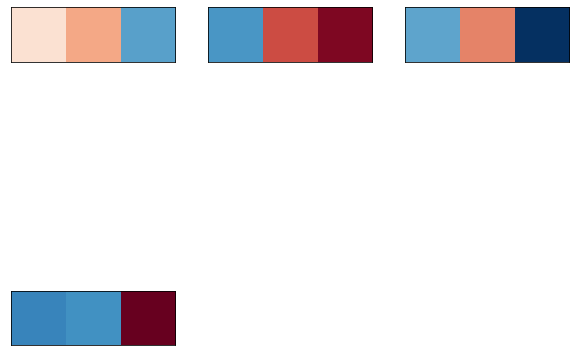

array([[0.8304259, 0.8044845, 0.       ]], dtype=float32)

In [71]:
filters = model.layers[1].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 4 , 1

fig, ax = plt.subplots(figsize=(10, 20))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = 0, vmax = 1)
        ix += 1

# show the figure
plt.show()
f[:, :, j]

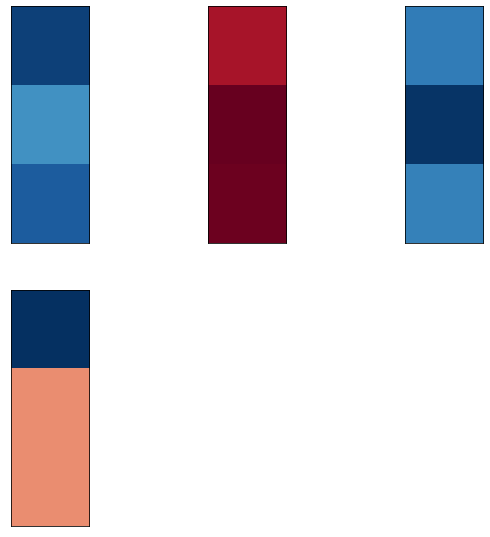

array([[1.        ],
       [0.26712948],
       [0.26578534]], dtype=float32)

In [73]:
filters = model.layers[2].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 4 , 1

fig, ax = plt.subplots(figsize=(10, 20))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = 0, vmax = 1)
        ix += 1

# show the figure
plt.show()
f[:, :, j]

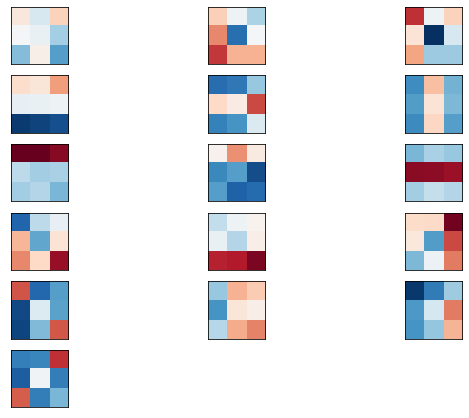

array([[0.84207964, 0.82427305, 0.13376746],
       [0.9133414 , 0.51616204, 0.84579164],
       [0.1956402 , 0.8450661 , 0.7289427 ]], dtype=float32)

In [76]:
filters = model.layers[3].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 16 , 1

fig, ax = plt.subplots(figsize=(10, 20))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = 0, vmax = 1)
        ix += 1

# show the figure
plt.show()
f[:, :, j]